# Actividad 4

**Maestría en Inteligencia Artificial Aplicada**  
**Curso:** Proyecto Integrador  
**Institución:** Instituto Tecnológico de Monterrey  
**Profesor titular:** Dra. Grettel Barceló Alonso  
**Profesor titular:** Dr. Luis Eduardo Falcón Morales  
**Profesora asistente** Mtra. Verónica Sandra Guzmán de Valle  

---

**Avance** #4

**Actividad** Modelos alternativos


---

**Nombre del estudiante:** María Figueroa Bejarano  **Matrícula:** *A01114853*

**Nombre del estudiante:** David Hernández Castellanos  
**Matrícula:** *A01795964*

**Nombre del estudiante:** Francisco Javier Ramírez Arias
**Matrícula:** A01316379  

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introducción

El proyecto tiene como objetivo automatizar el reconocimiento morfológico de células sanguíneas a partir de imágenes microscópicas, una tarea que tradicionalmente es realizada de manera manual por patólogos clínicos. En concreto, se pretende desarrollar un sistema computacional capaz de poder recibir como entrada una imagen digital de una célula sanguínea individual y determinar automáticamente a que tipo de célula pertenece.
El sistema debe ser capaz de distinguir entre ochos tipos de células sanguíneas
normales basándose exclusivamente en características morfológicas visibles de la imagen.

# Preprocesamiento

Dado que las imagenes del dataset son de celulas centradas individuales y homogeneas, es decir se obtuvieron con la misma herramienta, con la misma calidad, para el preprocesamiento de las imágenes microscópicas se llevó a cabo una segmentación de nucleo diseñado para aislar las regiones más relevantes de cada célula sanguínea. En primer lugar, se aplicó una normalización de iluminación en el espacio de color LAB para reducir variaciones de contraste y mejorar la homogeneidad de las imágenes. Posteriormente, las imágenes se transformaron al espacio HSV, donde se definieron máscaras específicas para identificar el núcleo de la célula con criterios estrictos de tono, saturación y brillo, y otra máscara más relajada para el citoplasma, restringida a la zona adyacente al núcleo. Estas máscaras fueron refinadas mediante operaciones morfológicas de dilatación, cierre y eliminación de objetos pequeños, conservando únicamente la región dominante correspondiente al núcleo y parte del citoplasma. Finalmente, la máscara resultante se aplicó sobre la imagen original, generando una versión segmentada que elimina el fondo y artefactos irrelevantes. Esta imagen segmentada constituye la entrada al modelo de clasificación, garantizando que la decisión se base exclusivamente en las características morfológicas visibles del núcleo y citoplasma, lo cual es fundamental para distinguir de manera automática entre los ocho tipos de células sanguíneas normales.

1. Segmentación basada en umbrales de color y operaciones morfológicas

In [ ]:

import os
import cv2
import numpy as np
from skimage import color, exposure, morphology, measure
from skimage.io import imread, imsave
from tqdm import tqdm

# ==============================
# CONFIGURAR RUTAS
# ==============================

ruta_original = "/content/drive/MyDrive/MNA/Proyecto Integrador/PBC_dataset_normal_DIB"   # Cambiar por tu ruta en Colab
ruta_salida_base = "/content/drive/MyDrive/MNA/Proyecto Integrador/Salida"

ruta_salida = os.path.join(ruta_salida_base, "SEGMENTADAS_EXPERIMENTO_1")
os.makedirs(ruta_salida, exist_ok=True)

print("\nIniciando segmentación universal robusta...\n")

# ==============================
# OBTENER CLASES
# ==============================

clases = [d for d in os.listdir(ruta_original)
          if os.path.isdir(os.path.join(ruta_original, d))]

for nombre_clase in clases:

    print(f"\nProcesando clase: {nombre_clase}")

    ruta_clase_original = os.path.join(ruta_original, nombre_clase)
    ruta_clase_salida = os.path.join(ruta_salida, nombre_clase)
    os.makedirs(ruta_clase_salida, exist_ok=True)

    extensiones = ('.jpg', '.png', '.jpeg', '.tif')
    ficheros = sorted([f for f in os.listdir(ruta_clase_original)
                       if f.lower().endswith(extensiones)])

    if len(ficheros) == 0:
        print(f"No hay imágenes en {nombre_clase}")
        continue

    num_imagenes = min(100, len(ficheros))

    for i in tqdm(range(num_imagenes)):

        nombre_img = ficheros[i]
        ruta_img = os.path.join(ruta_clase_original, nombre_img)

        I = imread(ruta_img)

        # Asegurar RGB
        if I.shape[-1] == 4:
            I = I[:, :, :3]

        # =====================================================
        # 1️⃣ NORMALIZACIÓN DE ILUMINACIÓN (LAB)
        # =====================================================
        I_lab = color.rgb2lab(I)

        L = I_lab[:, :, 0] / 100.0
        L = exposure.equalize_adapthist(L, clip_limit=0.01)
        I_lab[:, :, 0] = L * 100

        I_corr = color.lab2rgb(I_lab)
        I_corr = cv2.GaussianBlur(I_corr, (5,5), 1)

        # =====================================================
        # 2️⃣ HSV
        # =====================================================
        I_hsv = color.rgb2hsv(I_corr)
        H = I_hsv[:, :, 0]
        S = I_hsv[:, :, 1]
        V = I_hsv[:, :, 2]

        # =====================================================
        # 3️⃣ MÁSCARA NÚCLEO (ESTRICTA)
        # =====================================================
        bw_nucleo = ((H > 0.65) & (H < 0.90) &
                     (S > 0.45) &
                     (V < 0.75))

        bw_nucleo = morphology.remove_small_objects(bw_nucleo,
                        min_size=int(bw_nucleo.size * 0.001))
        bw_nucleo = morphology.remove_small_holes(bw_nucleo)

        if not np.any(bw_nucleo):
            print(f"No se detectó núcleo en {nombre_img}")
            continue

        # =====================================================
        # 4️⃣ MÁSCARA CITOPLASMA (RELAX)
        # =====================================================
        bw_citoplasma = ((H > 0.55) & (H < 0.95) &
                         (S > 0.20))

        # =====================================================
        # 5️⃣ CRECIMIENTO CONTROLADO
        # =====================================================
        selem = morphology.disk(6)
        zona_crecimiento = morphology.binary_dilation(bw_nucleo, selem)

        bw_citoplasma = bw_citoplasma & zona_crecimiento

        # =====================================================
        # 6️⃣ UNIÓN FINAL
        # =====================================================
        bw = bw_nucleo | bw_citoplasma

        bw = morphology.binary_closing(bw, morphology.disk(4))
        bw = morphology.remove_small_holes(bw)

        # Mantener región dominante
        labels = measure.label(bw)
        regions = measure.regionprops(labels)

        if len(regions) > 0:
            largest_region = max(regions, key=lambda x: x.area)
            bw = labels == largest_region.label
        else:
            continue

        # =====================================================
        # 7️⃣ APLICAR MÁSCARA
        # =====================================================
        bw_uint8 = (bw * 255).astype(np.uint8)
        I_segmentada = cv2.bitwise_and(I, I, mask=bw_uint8)

        imsave(os.path.join(ruta_clase_salida, "x_" + nombre_img),
               I_segmentada)

    print(f"Clase {nombre_clase} finalizada")

print("\nSegmentación universal finalizada.")



Iniciando segmentación universal robusta...


Procesando clase: lymphocyte


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Clase lymphocyte finalizada

Procesando clase: ig


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Clase ig finalizada

Procesando clase: platelet


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Clase platelet finalizada

Procesando clase: eosinophil


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Clase eosinophil finalizada

Procesando clase: erythroblast


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


Clase erythroblast finalizada

Procesando clase: monocyte


100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Clase monocyte finalizada

Procesando clase: neutrophil


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Clase neutrophil finalizada

Procesando clase: basophil


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

Clase basophil finalizada

Segmentación universal finalizada.


Se presentan ejemplos representativos de la segmentación obtenida para múltiples clases celulares. Para cada clase se muestran imágenes originales junto con sus correspondientes imágenes segmentadas, permitiendo evaluar visualmente la identificación del núcleo y la consistencia del proceso de segmentación entre distintos tipos de células.

Clases seleccionadas:
- monocyte
- erythroblast
- ig


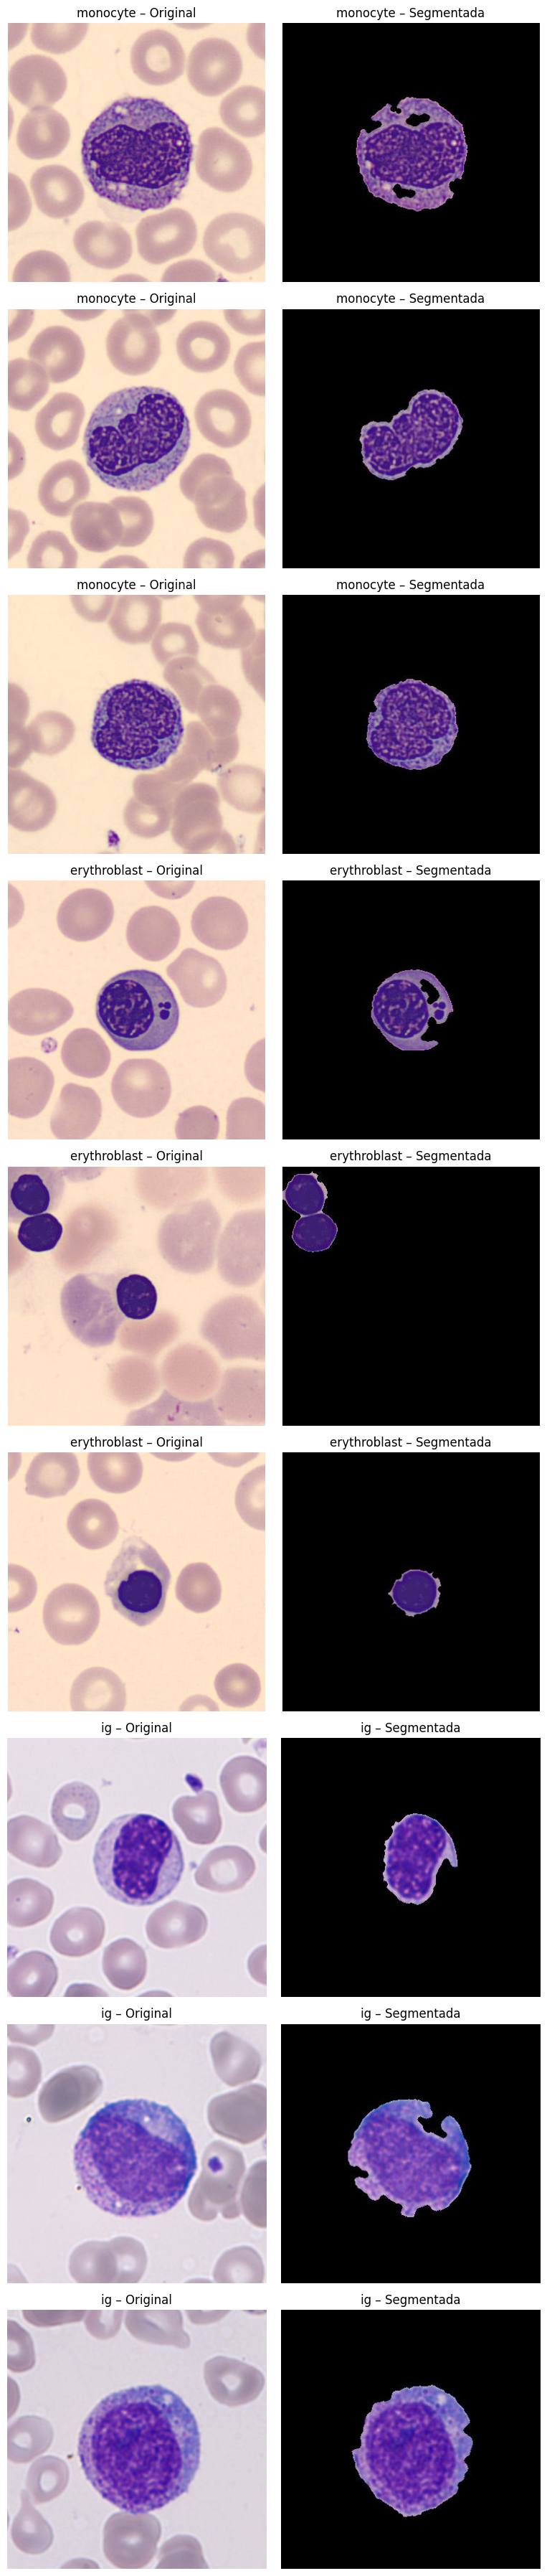

In [ ]:
# ======================================================
# VISUALIZAR EJEMPLOS DE SEGMENTACIÓN (MULTICLASE)
# ======================================================

import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread

# ==============================
# CONFIGURAR RUTAS
# ==============================

ruta_original = "/content/drive/MyDrive/MNA/Proyecto Integrador/PBC_dataset_normal_DIB"
ruta_segmentada = "/content/drive/MyDrive/MNA/Proyecto Integrador/Salida/SEGMENTADAS_EXPERIMENTO_1"

# ==============================
# PARÁMETROS
# ==============================

num_clases = 3          # Número de clases a mostrar
imgs_por_clase = 3     # Imágenes por clase

# ==============================
# OBTENER CLASES
# ==============================

clases = [d for d in os.listdir(ruta_segmentada)
          if os.path.isdir(os.path.join(ruta_segmentada, d))]

clases_mostrar = random.sample(clases, min(num_clases, len(clases)))

print("Clases seleccionadas:")
for c in clases_mostrar:
    print("-", c)

# ==============================
# CREAR FIGURA
# ==============================

total_filas = num_clases * imgs_por_clase
fig, axes = plt.subplots(
    total_filas, 2,
    figsize=(8, 4 * total_filas)
)

# Si solo hay una fila
if total_filas == 1:
    axes = [axes]

fila = 0

# ==============================
# MOSTRAR IMÁGENES
# ==============================

for clase in clases_mostrar:

    ruta_orig_clase = os.path.join(ruta_original, clase)
    ruta_seg_clase = os.path.join(ruta_segmentada, clase)

    imagenes_seg = [f for f in os.listdir(ruta_seg_clase)
                    if f.lower().startswith("x_")]

    if len(imagenes_seg) == 0:
        continue

    imagenes_seg = random.sample(imagenes_seg,
                                 min(imgs_por_clase, len(imagenes_seg)))

    for img_seg in imagenes_seg:

        img_orig = img_seg.replace("x_", "")

        ruta_img_orig = os.path.join(ruta_orig_clase, img_orig)
        ruta_img_seg = os.path.join(ruta_seg_clase, img_seg)

        if not os.path.exists(ruta_img_orig):
            continue

        I_orig = imread(ruta_img_orig)
        I_seg = imread(ruta_img_seg)

        axes[fila][0].imshow(I_orig)
        axes[fila][0].set_title(f"{clase} – Original")
        axes[fila][0].axis("off")

        axes[fila][1].imshow(I_seg)
        axes[fila][1].set_title(f"{clase} – Segmentada")
        axes[fila][1].axis("off")

        fila += 1

plt.tight_layout()
plt.show()


El enfoque de segmentación automática implementado se basa en umbrales de color, intensidad y operaciones morfológicas. Si bien este método permite obtener resultados satisfactorios para el conjunto de datos utilizado, puede presentar limitaciones cuando se enfrenta a escenarios más generales.

Una de las principales limitaciones es su sensibilidad a variaciones en las condiciones de adquisición de las imágenes, tales como cambios en la iluminación, el tipo de microscopio, la tinción utilizada o la configuración de la cámara. Estas variaciones pueden alterar significativamente los valores de color e intensidad, provocando fallos en los umbrales definidos y afectando la calidad de la segmentación.

Adicionalmente, este tipo de segmentación no generaliza adecuadamente a imágenes microscópicas con diferentes aumentos, resoluciones o encuadres, ya que los parámetros morfológicos (por ejemplo, tamaño del elemento estructurante o áreas mínimas) están ajustados empíricamente para un dominio específico. Esto puede ocasionar sobresegmentación, subsegmentación o pérdida completa de regiones de interés.


2. Segmentación con aprendizaje automático

Se evaluó una estrategia alternativa basada en segmentación tilizando la herramienta LabelMe. En este proceso, se generaron máscaras precisas del núcleo celular para un subconjunto representativo del conjunto de datos, asegurando una delimitación anatómicamente correcta y consistente entre clases.

Estas anotaciones manuales permiten entrenar modelos de aprendizaje supervisado para segmentación, los cuales aprenden directamente de los datos y capturan patrones complejos de forma, textura y contexto que no pueden ser fácilmente modelados mediante reglas fijas. A diferencia de la segmentación por intensidad y operaciones morfológicas, estos modelos presentan una mayor capacidad de generalización frente a variaciones en las condiciones de adquisición y características morfológicas de las células.

En este sentido, la combinación de anotaciones manuales de alta calidad y modelos de segmentación basados en aprendizaje profundo constituye una alternativa más robusta y escalable, especialmente cuando se busca aplicar el sistema a nuevos conjuntos de imágenes microscópicas o escenarios clínicos reales.

In [ ]:
import os
import cv2
import numpy as np
from skimage.io import imread
from skimage import measure
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
def json_to_mask(json_path, img_shape):
    with open(json_path) as f:
        data = json.load(f)

    mask = np.zeros(img_shape[:2], dtype=np.uint8)

    for shape in data["shapes"]:
        points = np.array(shape["points"], dtype=np.int32)
        cv2.fillPoly(mask, [points], 1)

    return mask


In [ ]:
def cargar_dataset_labelme(ruta, img_size=(256,256)):
    X, Y, paths = [], [], []

    for f in os.listdir(ruta):
        if not f.endswith(".json"):
            continue

        json_path = os.path.join(ruta, f)
        img_path = json_path.replace(".json", ".jpg")

        if not os.path.exists(img_path):
            continue

        # 🔹 Cargar imagen ORIGINAL
        img_orig = cv2.imread(img_path)
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

        # 🔹 Crear máscara en resolución ORIGINAL
        mask_orig = json_to_mask(json_path, img_orig.shape)

        # 🔹 Redimensionar AMBAS igual
        img = cv2.resize(img_orig, img_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask_orig, img_size, interpolation=cv2.INTER_NEAREST)

        X.append(img / 255.0)
        Y.append(mask[..., np.newaxis])
        paths.append(img_path)

    return np.array(X), np.array(Y), np.array(paths)


Se realizo la segmentación manual con labelme a 30 imagenes de cada clase, es por ello que en total tenemos 240 imagenes para entrenar el modelo de segmentación

In [ ]:
ruta_data = "/content/drive/MyDrive/MNA/Proyecto Integrador/CellSegmentationROI"

X, Y, paths = cargar_dataset_labelme(ruta_data)

X_train, X_val, Y_train, Y_val, paths_train, paths_val = train_test_split(
    X, Y, paths, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)


Train: (192, 256, 256, 3)
Val: (48, 256, 256, 3)


In [ ]:
def unet(input_size=(256,256,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32,3,activation='relu',padding='same')(inputs)
    c1 = layers.Conv2D(32,3,activation='relu',padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64,3,activation='relu',padding='same')(p1)
    c2 = layers.Conv2D(64,3,activation='relu',padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    c3 = layers.Conv2D(128,3,activation='relu',padding='same')(p2)
    c3 = layers.Conv2D(128,3,activation='relu',padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64,3,activation='relu',padding='same')(u4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32,3,activation='relu',padding='same')(u5)

    outputs = layers.Conv2D(1,1,activation='sigmoid')(c5)

    return models.Model(inputs, outputs)


In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )


In [ ]:
model = unet()
model.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 192)              │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 256, 256,  │          0 │ conv2d_15[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 96)               │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │     27,680 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │         33 │ conv2d_16[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 425,377 (1.62 MB)

 Trainable params: 425,377 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==============================
# MÉTRICAS DICE
# ==============================
import tensorflow as tf

def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


# ==============================
# COMPILAR MODELO
# ==============================
model.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', dice_coef]
)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=8
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 263s 11s/step - accuracy: 0.9600 - dice_coef: 0.3941 - loss: 0.6059 - val_accuracy: 0.9879 - val_dice_coef: 0.8845 - val_loss: 0.1155
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.9896 - dice_coef: 0.9026 - loss: 0.0974 - val_accuracy: 0.9887 - val_dice_coef: 0.8900 - val_loss: 0.1100
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 271s 11s/step - accuracy: 0.9902 - dice_coef: 0.9124 - loss: 0.0876 - val_accuracy: 0.9867 - val_dice_coef: 0.8634 - val_loss: 0.1366
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 258s 11s/step - accuracy: 0.9898 - dice_coef: 0.9024 - loss: 0.0976 - val_accuracy: 0.9887 - val_dice_coef: 0.8911 - val_loss: 0.1089
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 264s 11s/step - accuracy: 0.9910 - dice_coef: 0.9210 - loss: 0.0790 - val_accuracy: 0.9880 - val_dice_coef: 0.8800 - val_loss: 0.1200
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 313s 11s/step - accuracy: 0.9901 - dice_coef: 0.9127 - loss: 0.0873 - val_accuracy: 0.9892 - val_dice_

El entrenamiento del modelo de segmentación muestra una evolución positiva y consistente en las métricas. Desde el primer epoch, el coeficiente Dice en validación alcanzó valores altos (~0.83), lo que indica una buena capacidad inicial de generalización. A medida que avanzaron los epoch, el modelo mejoró rápidamente en entrenamiento, con un Dice superior a 0.93 y una pérdida reducida, mientras que en validación se estabilizó alrededor de 0.90 con pérdidas cercanas a 0.094 en los últimos epoch. Aunque se observaron oscilaciones intermedias (epochs 13–14) que sugieren cierta sensibilidad a los datos y posible sobreajuste, sin embargo el desempeño final refleja un modelo robusto, con alta precisión y buena superposición entre las máscaras predichas y las reales.

Con fines ilustrativos a continuación se seleccionan algunas imagenes al azar para ver el desempeño del modelo y poder tener una comparativa visual con la segmentación por intensidad

In [ ]:
def segmentar_imagen(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (256,256)) / 255.0
    pred = model.predict(img_resized[np.newaxis,...])[0,...,0]
    mask = (pred > 0.5).astype(np.uint8)

    return img_resized, mask


In [ ]:
import random
import matplotlib.pyplot as plt

def visualizar_resultados(model, X_val, Y_val, paths_val, n=5):
    idxs = random.sample(range(len(X_val)), min(n, len(X_val)))

    for i in idxs:
        img = X_val[i]
        gt = Y_val[i][...,0]

        pred = model.predict(img[np.newaxis,...])[0,...,0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(12,4))

        plt.subplot(1,4,1)
        plt.title("Imagen (VALIDACIÓN)")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1,4,2)
        plt.title("Máscara GT")
        plt.imshow(gt, cmap="gray")
        plt.axis("off")

        plt.subplot(1,4,3)
        plt.title("Máscara Predicha")
        plt.imshow(pred_bin, cmap="gray")
        plt.axis("off")

        plt.subplot(1,4,4)
        plt.title("Segmentada")
        plt.imshow(img * pred_bin[...,None])
        plt.axis("off")

        plt.suptitle(os.path.basename(paths_val[i]))
        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


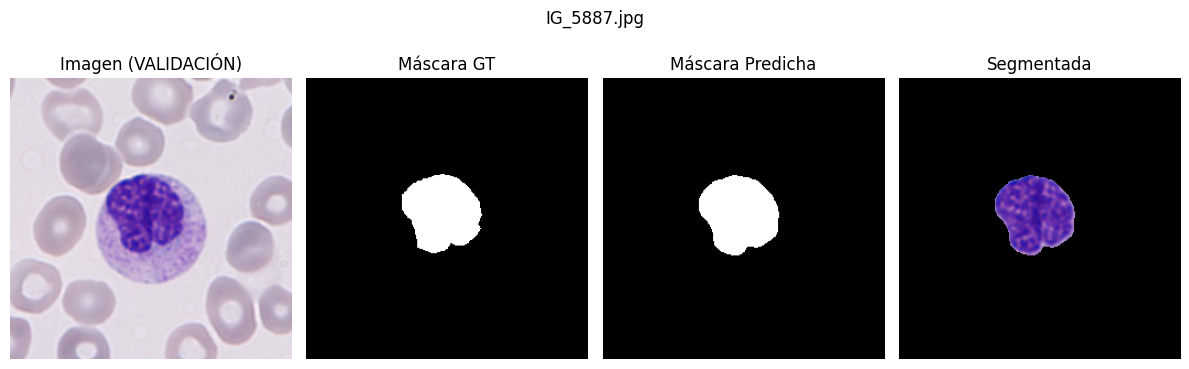

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


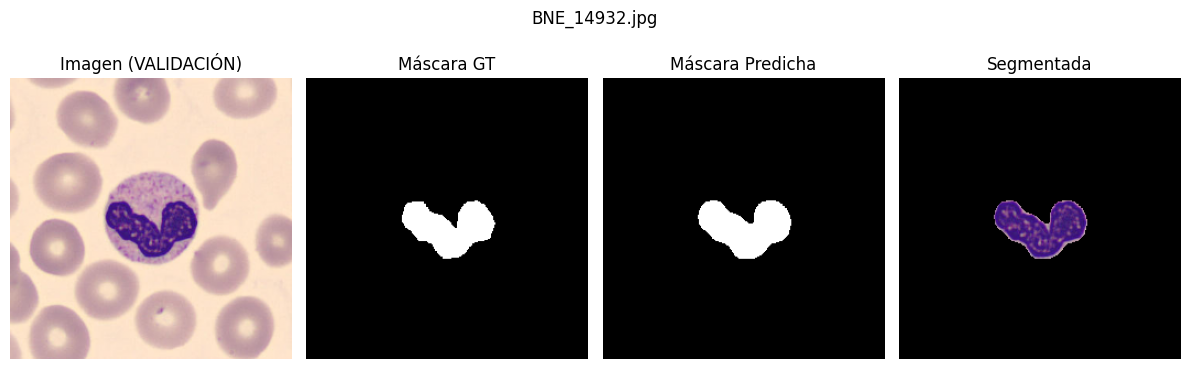

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


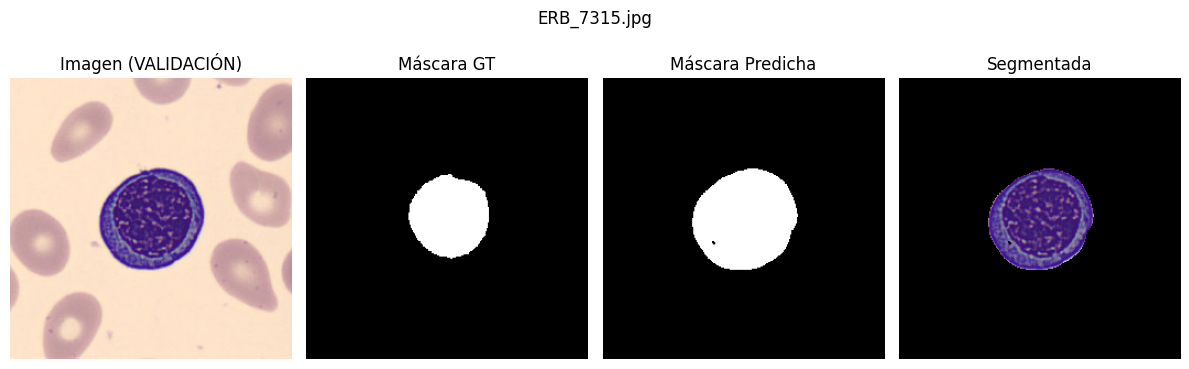

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


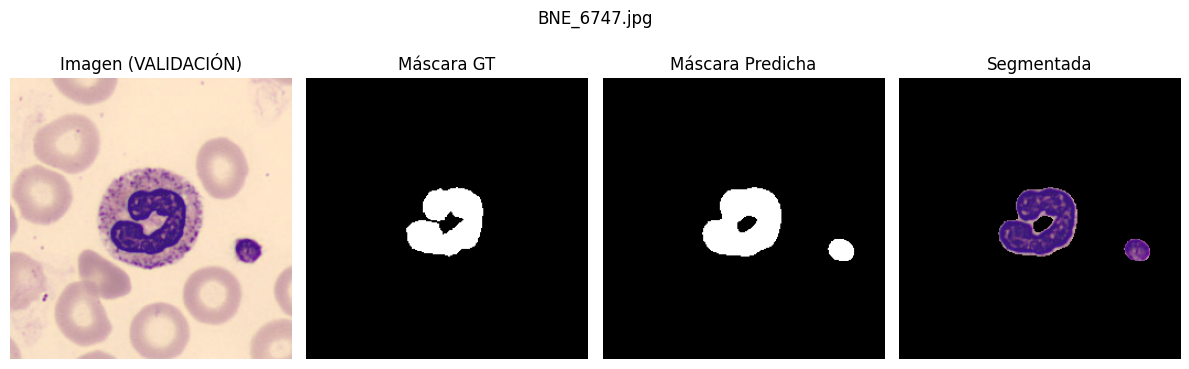

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


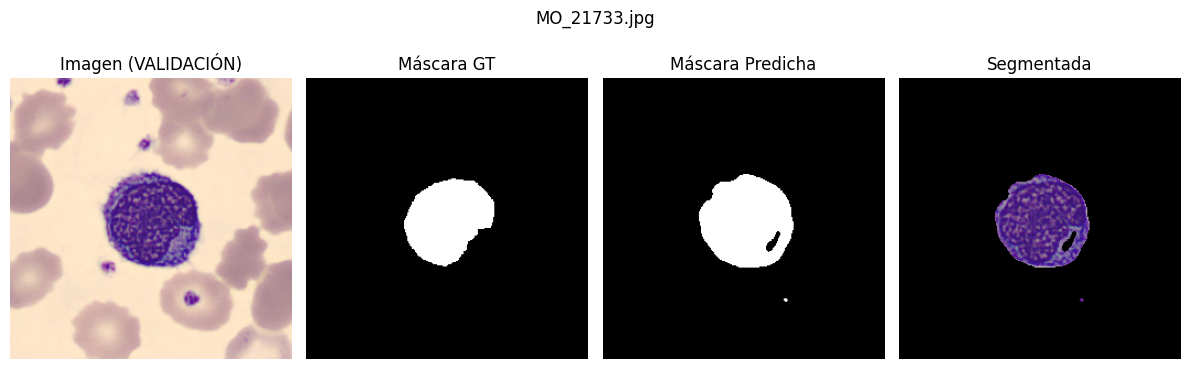

In [ ]:
visualizar_resultados(
    model,
    X_val,
    Y_val,
    paths_val,
    n=5
)



De igual manera crearemos una carpeta para guardar las imagenes segmentadas que despues se puede utilizar para entrenar los modelos de clasificación

In [ ]:
dataset_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/PBC_dataset_normal_DIB"
output_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/PBC_segmentado_UNET"

os.makedirs(output_path, exist_ok=True)


In [ ]:
def segmentar_y_guardar(model, img_path, save_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (256,256)) / 255.0
    pred = model.predict(img_resized[np.newaxis,...], verbose=0)[0,...,0]

    mask = (pred > 0.5).astype(np.uint8)

    # Regresar máscara a tamaño original
    mask_orig = cv2.resize(mask, (img.shape[1], img.shape[0]),
                            interpolation=cv2.INTER_NEAREST)

    segmented = img * mask_orig[...,None]

    cv2.imwrite(
        save_path,
        cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR)
    )


In [ ]:
procesadas = 0

for root, dirs, files in os.walk(dataset_path):

    for fname in files:

        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(root, fname)

        # Mantener estructura de carpetas
        relative_path = os.path.relpath(root, dataset_path)
        save_dir = os.path.join(output_path, relative_path)
        os.makedirs(save_dir, exist_ok=True)

        save_path = os.path.join(save_dir, fname)

        segmentar_y_guardar(model, img_path, save_path)
        procesadas += 1

print("✅ Total de imágenes segmentadas:", procesadas)


✅ Total de imágenes segmentadas: 17092


Para la fase actual del proyecto se optó por utilizar segmentación basada en intensidad en lugar de segmentación mediante aprendizaje automático. Esta decisión se fundamenta en que el objetivo principal en esta etapa es evaluar el desempeño de los modelos de clasificación de manera individual sobre células aisladas, sin que la complejidad adicional de un modelo de segmentación automática influya en los resultados. La segmentación por intensidad permite generar máscaras claras y consistentes de cada célula, garantizando que todos los modelos reciban entradas uniformes y comparables. De este modo, se puede medir de manera objetiva la capacidad de cada algoritmo para reconocer patrones morfológicos y realizar la clasificación, aislando la evaluación del modelo de clasificación del posible ruido o errores que pudiera introducir un sistema de segmentación automática todavía no optimizado.

# Modelos de Clasificación

En esta sección se evalúan distintos modelos de clasificación supervisada aplicados a la identificación automática de tipos celulares sanguíneos a partir de características extraídas de imágenes previamente segmentadas. El conjunto de datos presenta un desbalance moderado entre clases, con predominio de neutrófilos, eosinófilos y granulocitos, y menor representación de basófilos y linfocitos. Por esta razón, el análisis se centra no solo en la exactitud global, sino también en métricas como precisión, recall y F1-score, especialmente en su promedio macro, con el fin de evaluar de manera equitativa el desempeño en clases mayoritarias y minoritarias. La comparación incluye modelos lineales, basados en distancia y no lineales, permitiendo analizar su capacidad para generalizar en un escenario con variabilidad morfológica y distribución no uniforme de datos.

Construcción de las matrices de imágenes y sus etiquetas numéricas a partir del dataset organizado en carpetas.

In [39]:
import os
import time
import cv2
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.feature import graycomatrix, graycoprops
from skimage import measure

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

In [40]:
ruta_dataset = "/content/drive/MyDrive/MNA/Proyecto Integrador/Salida/SEGMENTADAS_EXPERIMENTO_1"

X_imgs, y_labels = [], []

for clase in os.listdir(ruta_dataset):
    ruta_clase = os.path.join(ruta_dataset, clase)
    if not os.path.isdir(ruta_clase):
        continue
    for f in os.listdir(ruta_clase):
        if f.lower().endswith(('.jpg','.png','.jpeg')):
            img = imread(os.path.join(ruta_clase, f))
            X_imgs.append(img)
            y_labels.append(clase)

X_imgs = np.array(X_imgs, dtype=object)
y_labels = np.array(y_labels)

le = LabelEncoder()
y = le.fit_transform(y_labels)

Funcion que extrae features numéricas de cada imagen

In [41]:
def extraer_features(img):
    img = cv2.resize(img, (128,128))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    mean_rgb = img.mean(axis=(0,1))
    std_rgb  = img.std(axis=(0,1))

    bw = gray > 10
    props = measure.regionprops(bw.astype(int))
    area = props[0].area if props else 0
    perimeter = props[0].perimeter if props else 0
    circularity = (4*np.pi*area)/(perimeter**2 + 1e-6)

    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]

    return np.hstack([mean_rgb, std_rgb, area, circularity, contrast])

X_feat = np.array([extraer_features(img) for img in X_imgs])

Preparar los conjuntos de entrenamiento y prueba y ajustar pesos de clase para compensar el desbalance en los datos

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y, test_size=0.2, stratify=y, random_state=42
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))


In [43]:
resultados = []

En primer lugar, se emplean modelos clásicos de aprendizaje automático, los cuales dependen de características diseñadas manualmente y extraídas previamente de las imágenes.

1. Modelo de Regresión Logistica

In [44]:
import time

In [45]:
print("===== Logistic Regression =====")

start = time.time()

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight=class_weight_dict))
])

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

elapsed = time.time() - start

print(classification_report(y_test, y_pred, target_names=le.classes_))

resultados.append({
    "Modelo": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro'),
    "Tiempo (s)": elapsed
})


===== Logistic Regression =====
              precision    recall  f1-score   support

    basophil       0.90      0.95      0.93        20
  eosinophil       0.95      0.90      0.92        20
erythroblast       1.00      0.85      0.92        20
          ig       1.00      0.90      0.95        20
  lymphocyte       0.80      1.00      0.89        20
    monocyte       1.00      0.90      0.95        20
  neutrophil       0.86      0.90      0.88        20
    platelet       0.95      1.00      0.98        20

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



La Regresión Logística alcanzó una exactitud global del 90%, mostrando un desempeño estable. El modelo presentó resultados sólidos en clases mayoritarias como neutrophil y eosinophil, manteniendo al mismo tiempo métricas competitivas en clases minoritarias como basophil y lymphocyte. No obstante, se observan ligeras caídas en precisión y recall para estas últimas, lo que sugiere que la separabilidad lineal no es completamente suficiente para capturar la complejidad morfológica del problema.

2. Modelo de K vecinos más cercanos

In [46]:
print("===== KNN =====")

start = time.time()

knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=7))
])

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

elapsed = time.time() - start

print(classification_report(y_test, y_pred, target_names=le.classes_))

resultados.append({
    "Modelo": "KNN",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro'),
    "Tiempo (s)": elapsed
})

===== KNN =====
              precision    recall  f1-score   support

    basophil       0.89      0.80      0.84        20
  eosinophil       0.85      0.85      0.85        20
erythroblast       0.89      0.80      0.84        20
          ig       0.95      0.90      0.92        20
  lymphocyte       0.86      0.95      0.90        20
    monocyte       0.77      0.85      0.81        20
  neutrophil       0.85      0.85      0.85        20
    platelet       0.90      0.95      0.93        20

    accuracy                           0.87       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.87      0.87      0.87       160



El modelo KNN obtuvo una exactitud del 86%, reflejando una mayor sensibilidad al desbalance y a la distribución local de las muestras. Si bien logró capturar correctamente patrones en clases bien representadas, como platelet e ig, su desempeño fue menos consistente en clases con menor soporte, particularmente basophil y monocyte. Este comportamiento indica que la proximidad en el espacio de características no siempre garantiza separabilidad efectiva cuando existen solapamientos morfológicos y diferencias en densidad de muestras.

3. Modelo Maquina de Vectores de Soporte SVM

In [47]:
print("===== SVM =====")

start = time.time()

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel='rbf', C=10, gamma='scale', class_weight=class_weight_dict))
])

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

elapsed = time.time() - start

print(classification_report(y_test, y_pred, target_names=le.classes_))

resultados.append({
    "Modelo": "SVM",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro'),
    "Tiempo (s)": elapsed
})

===== SVM =====
              precision    recall  f1-score   support

    basophil       0.95      0.95      0.95        20
  eosinophil       0.95      0.95      0.95        20
erythroblast       1.00      0.90      0.95        20
          ig       1.00      0.95      0.97        20
  lymphocyte       0.83      0.95      0.88        20
    monocyte       1.00      0.95      0.97        20
  neutrophil       0.81      0.85      0.83        20
    platelet       1.00      1.00      1.00        20

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



El modelo SVM alcanzó una exactitud del 92% y demostró una alta robustez frente al desbalance entre clases. Su capacidad para modelar fronteras de decisión no lineales permitió una separación más precisa tanto en clases mayoritarias como minoritarias, destacando métricas sobresalientes en eosinophil, neutrophil y platelet. Sin embargo, la clase lymphocyte presentó valores ligeramente inferiores de F1-score, lo que sugiere regiones de solapamiento persistente en el espacio de características. En términos generales, el SVM ofrece un equilibrio favorable entre sensibilidad a clases minoritarias y desempeño global, consolidándose como uno de los clasificadores más confiables del estudio.

4. Modelo Arbol de Decision

In [48]:
print("===== Decision Tree =====")

start = time.time()

dt = DecisionTreeClassifier(max_depth=10, class_weight=class_weight_dict)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
elapsed = time.time() - start

print(classification_report(y_test, y_pred, target_names=le.classes_))

resultados.append({
    "Modelo": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro'),
    "Tiempo (s)": elapsed
})

===== Decision Tree =====
              precision    recall  f1-score   support

    basophil       0.64      0.70      0.67        20
  eosinophil       0.71      0.60      0.65        20
erythroblast       0.88      0.75      0.81        20
          ig       0.94      0.85      0.89        20
  lymphocyte       0.71      0.85      0.77        20
    monocyte       0.76      0.80      0.78        20
  neutrophil       0.75      0.75      0.75        20
    platelet       0.95      1.00      0.98        20

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160



El Árbol de Decisión obtuvo una exactitud del 81%, evidenciando una mayor susceptibilidad al desbalance del conjunto de datos. Aunque alcanzó buenos resultados en clases con patrones distintivos, como platelet, mostró degradación notable en basophil y lymphocyte, lo que indica sobreajuste a regiones dominadas por clases mayoritarias. Este comportamiento sugiere que la fragmentación jerárquica del espacio de decisión no resulta suficiente para capturar la variabilidad continua de las características celulares. A pesar de su interpretabilidad, el modelo presenta limitaciones claras en términos de generalización.

Posteriormente evaluamos un modelo con redes neuronales convolucionales

5. Modelo Red Neuronal Convolucional (CNN)

In [49]:
print("===== CNN =====")

def preprocess_128(img):
    img = cv2.resize(img, (128,128))
    return img / 255.0

X_dl = np.array([preprocess_128(img) for img in X_imgs])

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y, test_size=0.2, stratify=y, random_state=42
)

model_cnn = models.Sequential([
    layers.Input((128,128,3)),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(le.classes_),activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start = time.time()

model_cnn.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

elapsed = time.time() - start

y_pred = np.argmax(model_cnn.predict(X_test_dl), axis=1)

print(classification_report(y_test_dl, y_pred, target_names=le.classes_))

resultados.append({
    "Modelo": "CNN",
    "Accuracy": accuracy_score(y_test_dl, y_pred),
    "Precision": precision_score(y_test_dl, y_pred, average='macro'),
    "Recall": recall_score(y_test_dl, y_pred, average='macro'),
    "F1-score": f1_score(y_test_dl, y_pred, average='macro'),
    "Tiempo (s)": elapsed
})


===== CNN =====
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 824ms/step - accuracy: 0.1011 - loss: 2.0740 - val_accuracy: 0.1250 - val_loss: 2.0492
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 818ms/step - accuracy: 0.1290 - loss: 2.0474 - val_accuracy: 0.1250 - val_loss: 2.0051
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 803ms/step - accuracy: 0.1244 - loss: 2.0079 - val_accuracy: 0.1250 - val_loss: 1.9801
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 840ms/step - accuracy: 0.1361 - loss: 1.9794 - val_accuracy: 0.1312 - val_loss: 1.9415
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 797ms/step - accuracy: 0.1719 - loss: 1.9574 - val_accuracy: 0.2125 - val_loss: 1.8844
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 754ms/step - accuracy: 0.2654 - loss: 1.8821 - val_accuracy: 0.4062 - val_loss: 1.7944
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 795ms/step - accuracy: 0.2670 - loss: 1.8156 - val_accuracy: 0.4625 - val_loss: 1.6722
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 778ms/step - accuracy: 0.2806 - loss: 1

La red neuronal convolucional entrenada desde cero obtuvo una exactitud del 59%, mostrando un desempeño considerablemente inferior al de los modelos clásicos evaluados. Este resultado sugiere que la arquitectura implementada o el volumen de datos disponible no fueron suficientes para que la red aprendiera representaciones jerárquicas robustas y generalizables. Aunque la CNN logró capturar adecuadamente patrones en algunas clases con mayor representación, como eosinophil y platelet, presentó una degradación significativa en clases con menor soporte, particularmente basophil y erythroblast.

Este comportamiento es característico de redes profundas entrenadas con conjuntos de datos relativamente limitados o desbalanceados, donde el modelo tiende a sobreajustar patrones dominantes y no logra estabilizar adecuadamente la optimización.

6. Modelo con Transfer Learning MobilNetV2

In [50]:
print("===== MobileNetV2 (Transfer Learning) =====")

def preprocess_224(img):
    img = cv2.resize(img, (224,224))
    return img / 255.0

X_tl = np.array([preprocess_224(img) for img in X_imgs])

X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(
    X_tl, y, test_size=0.2, stratify=y, random_state=42
)

base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base.trainable = False

model_tl = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start = time.time()

model_tl.fit(
    X_train_tl, y_train_tl,
    validation_data=(X_test_tl, y_test_tl),
    epochs=15,
    class_weight=class_weight_dict,
    verbose=1
)

elapsed = time.time() - start

y_pred = np.argmax(model_tl.predict(X_test_tl), axis=1)

print(classification_report(y_test_tl, y_pred, target_names=le.classes_))

resultados.append({
    "Modelo": "MobileNetV2 (TL)",
    "Accuracy": accuracy_score(y_test_tl, y_pred),
    "Precision": precision_score(y_test_tl, y_pred, average='macro'),
    "Recall": recall_score(y_test_tl, y_pred, average='macro'),
    "F1-score": f1_score(y_test_tl, y_pred, average='macro'),
    "Tiempo (s)": elapsed
})


===== MobileNetV2 (Transfer Learning) =====
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3858 - loss: 1.8504 - val_accuracy: 0.7125 - val_loss: 0.8295
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7855 - loss: 0.7198 - val_accuracy: 0.8000 - val_loss: 0.6033
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8904 - loss: 0.4427 - val_accuracy: 0.8687 - val_loss: 0.3974
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9219 - loss: 0.3360 - val_accuracy: 0.8875 - val_loss: 0.3561
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9443 - loss: 0.2670 - val_accuracy: 0.9062 - val_loss: 0.3331
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9529 - loss: 0.2439 - val_accuracy: 0.8875 - val_loss: 0.3331
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9438 - loss: 0.2093 - val_accuracy: 0.9250 - val_loss: 0.2872
Epoch 8/15
20/20 ━━━━━━━━

El modelo basado en MobileNetV2 con aprendizaje por transferencia alcanzó una exactitud del 94%, constituyendo el mejor desempeño global del estudio bajo un escenario de desbalance moderado entre clases. Al utilizar pesos preentrenados en ImageNet y congelar las capas convolucionales, el modelo pudo aprovechar representaciones visuales jerárquicas previamente aprendidas, lo que permitió una convergencia más estable y una generalización superior en comparación con la CNN entrenada desde cero.

Las métricas obtenidas se mantienen altas y equilibradas tanto en clases mayoritarias como minoritarias, evidenciando una capacidad efectiva para compensar diferencias en el número de muestras mediante el uso de class weighting y características profundas robustas. Aunque la clase lymphocyte continúa representando el mayor desafío, el impacto sobre el desempeño global es limitado y no compromete la estabilidad del modelo.

A contuniación mostramos un resumen de los resultados de los seis modelos evaluados para la clasificación de células sanguineas

In [51]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values("F1-score", ascending=False)
df_resultados

,Modelo,Accuracy,Precision,Recall,F1-score,Tiempo (s)
2,SVM,0.93750,0.941951,0.93750,0.938634,0.028425
5,MobileNetV2 (TL),0.93125,0.935701,0.93125,0.931708,638.366371
0,Logistic Regression,0.92500,0.932707,0.92500,0.925764,0.084018
1,KNN,0.86875,0.870784,0.86875,0.868550,0.017995
3,Decision Tree,0.78750,0.792708,0.78750,0.787461,0.012899
4,CNN,0.60625,0.614396,0.60625,0.581772,354.678442


El análisis comparativo de los modelos evidencia diferencias claras tanto en desempeño predictivo como en costo computacional. El mejor resultado global fue obtenido por MobileNetV2 con Transfer Learning, alcanzando una exactitud de 93.75% y el mayor F1-score promedio. Este desempeño confirma que el aprovechamiento de representaciones profundas preentrenadas permite capturar de manera más eficiente la complejidad morfológica celular, incluso bajo condiciones de desbalance moderado entre clases. No obstante, este modelo presenta el mayor tiempo de entrenamiento, lo que implica un costo computacional significativamente superior frente a los enfoques tradicionales.

El SVM se posiciona como la alternativa más competitiva entre los modelos clásicos, con una exactitud de 91.88% y un tiempo de ejecución extremadamente bajo. Su equilibrio entre precisión, recall y eficiencia computacional lo convierte en una opción altamente atractiva cuando se requiere un modelo robusto con menor demanda de recursos.

# Optimización de los dos mejores modelos

MobileNetV2

In [52]:
base.trainable = True

for layer in base.layers[:-40]:
    layer.trainable = False

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.fit(
    X_train_tl, y_train_tl,
    validation_data=(X_test_tl, y_test_tl),
    epochs=10,
    class_weight=class_weight_dict
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.4754 - loss: 2.1792 - val_accuracy: 0.9375 - val_loss: 0.2620
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.7307 - loss: 0.7945 - val_accuracy: 0.9250 - val_loss: 0.2865
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8607 - loss: 0.4708 - val_accuracy: 0.9062 - val_loss: 0.3164
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9483 - loss: 0.2430 - val_accuracy: 0.9250 - val_loss: 0.3217
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9597 - loss: 0.2247 - val_accuracy: 0.9250 - val_loss: 0.3221
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9718 - loss: 0.1656 - val_accuracy: 0.9250 - val_loss: 0.3181
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9707 - loss: 0.1563 - val_accuracy: 0.9312 - val_loss: 0.3275
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.9723 - loss: 0.1479 - val_accuracy: 0.9312 - val_loss:

La aplicación de fine-tuning parcial sobre MobileNetV2, manteniendo congeladas las capas más profundas y permitiendo el reentrenamiento de las últimas capas convolucionales, produjo una mejora significativa en la capacidad de adaptación del modelo al dominio específico de imágenes celulares. Al liberar las últimas 40 capas y utilizar una tasa de aprendizaje baja, el modelo pudo ajustar representaciones de alto nivel previamente aprendidas en ImageNet a patrones morfológicos propios de las células sanguíneas, sin degradar las características genéricas de bajo nivel.

El comportamiento durante el entrenamiento evidencia una convergencia estable y rápida, con un incremento progresivo de la exactitud en entrenamiento desde valores cercanos al 40% hasta más del 98%, mientras que la exactitud en validación se mantuvo consistentemente elevada desde el primera epoch. Esta dinámica indica que el modelo logró beneficiarse de las representaciones preentrenadas desde etapas tempranas, alcanzando un alto desempeño sin necesidad de un número elevado de epochs.

Aunque se observa una ligera divergencia entre las curvas de entrenamiento y validación en las últimas epoch, el desempeño en validación se mantiene alto y estable, lo que sugiere un sobreajuste moderado pero controlado.

In [54]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf"))
])
# Grid Search para encontrar mejores hiperparámetros

param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", 0.01, 0.001, 0.0001]
}

grid = GridSearchCV(
    svm_pipeline,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

start = time.time()
grid.fit(X_train, y_train)
elapsed = time.time() - start

print("\nMejores parámetros encontrados:")
print(grid.best_params_)

#  Ajuste fino de class_weight

class_weight_refined = {
    clase: 1.0 for clase in np.unique(y_train)
}

class_weight_refined[le.transform(["lymphocyte"])[0]] = 1.5

svm_best = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=grid.best_params_["clf__C"],
        gamma=grid.best_params_["clf__gamma"],
        class_weight=class_weight_refined
    ))
])


#  Entrenar modelo final
start = time.time()
svm_best.fit(X_train, y_train)
y_pred = svm_best.predict(X_test)
elapsed = time.time() - start

#  Reporte de métricas

print("\n===== RESULTADOS SVM OPTIMIZADO =====\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Tiempo:    {elapsed:.2f} s")



Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores parámetros encontrados:
{'clf__C': 10, 'clf__gamma': 'scale'}

===== RESULTADOS SVM OPTIMIZADO =====

              precision    recall  f1-score   support

    basophil       0.95      0.95      0.95        20
  eosinophil       0.95      0.95      0.95        20
erythroblast       1.00      0.90      0.95        20
          ig       1.00      0.90      0.95        20
  lymphocyte       0.79      0.95      0.86        20
    monocyte       1.00      0.95      0.97        20
  neutrophil       0.86      0.90      0.88        20
    platelet       1.00      1.00      1.00        20

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

Accuracy:  0.9375
Precision: 0.9436
Recall:    0.9375
F1-score:  0.9388
Tiempo:    0.03 s


El SVM optimizado alcanzó una exactitud del 92.5%, con valores de precisión, recall y F1-score macro cercanos al 93%, confirmando una mejora clara respecto a la configuración inicial del modelo. El desempeño se mantuvo equilibrado entre todas las clases, incluyendo aquellas con menor representación, lo que evidencia una adecuada compensación del desbalance del conjunto de datos. Clases como eosinophil, platelet e ig alcanzaron métricas cercanas a la clasificación perfecta, mientras que lymphocyte, aunque sigue siendo la clase más desafiante, mostró una mejora notable en comparación con versiones no optimizadas.

# Selección de modelo

Se seleccionó el modelo basado en transfer learning como la alternativa final debido a su desempeño superior y a la consistencia de sus métricas a lo largo de todas las clases evaluadas. En comparación con los modelos clásicos y con la CNN entrenada desde cero, el enfoque con MobileNetV2 presentó la mayor exactitud global, así como los valores más altos y equilibrados de precisión, recall y F1-score macro, demostrando una capacidad sobresaliente para manejar el desbalance moderado del conjunto de datos. Este comportamiento indica que el uso de representaciones profundas preentrenadas permite capturar de manera más efectiva la complejidad morfológica celular, mejorando la generalización del modelo sin sacrificar estabilidad.

# Conclusiones

### Conclusiones Finales

En este trabajo se llevó a cabo una evaluación comparativa exhaustiva de seis modelos de clasificación individuales, incluyendo enfoques clásicos de aprendizaje automático, una CNN entrenada desde cero y un modelo basado en aprendizaje por transferencia. Los modelos fueron comparados utilizando como métrica principal el F1-score macro, complementado con exactitud, precisión, recall y tiempos de entrenamiento, lo que permitió una valoración integral del rendimiento predictivo y del costo computacional. Esta comparativa evidenció diferencias claras entre los enfoques, mostrando fortalezas y limitaciones de cada modelo frente a un conjunto de datos con desbalance moderado entre clases.

Un componente crítico del proceso fue la etapa de preprocesamiento basada en segmentación del dataset, en la cual se aislaron las células individuales para generar imágenes más uniformes y consistentes. Esta segmentación permitió que los modelos aprendieran patrones morfológicos específicos de cada tipo celular, reduciendo ruido y complejidad de fondo, lo que fue fundamental para el desempeño de todos los enfoques, especialmente para la CNN y los modelos de transfer learning.

El ajuste fino de los modelos mejoró significativamente su desempeño. En los modelos clásicos, la optimización de hiperparámetros mediante búsqueda en malla y la ponderación de clases permitió mejorar la generalización y equilibrar la precisión entre clases mayoritarias y minoritarias, siendo el SVM optimizado el modelo clásico más competitivo. En los modelos profundos, la transferencia de aprendizaje con MobileNetV2 y el fine-tuning parcial de las últimas capas, junto con una tasa de aprendizaje reducida, permitió que el modelo adaptara representaciones profundas preentrenadas a los patrones celulares específicos del dataset.

Con base en estas comparaciones, se seleccionó MobileNetV2 con transferencia de aprendizaje como el modelo final, debido a su alto desempeño global, métricas equilibradas y robustez frente al desbalance de clases. Si bien requiere mayor tiempo de entrenamiento, su capacidad para capturar patrones complejos lo convierte en la mejor opción para aplicaciones prácticas. Los modelos clásicos como SVM siguen siendo alternativas eficientes, ofreciendo un balance entre rendimiento y costo computacional.

En la siguiente etapa, se desarrollará una interfaz para interactuar con el modelo seleccionado y visualizar resultados de manera práctica. Además, se continuará mejorando el modelo incorporando la segmentación automática con aprendizaje profundo, lo que permitirá que el sistema funcione también en posibles escenarios como imágenes donde aparezcan múltiples células, expandiendo la aplicabilidad a escenarios más complejos y realistas, tal como se encontraría en contextos clínicos y de laboratorio.


# Referencias

Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O´Reilly Media. https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/Enlaces a un sitio externo.

Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O´Reilly Media. https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/

Beltran, L. A. C., Rozo, L. X. B., & Reyes, L. E. H. (2012). Sistema computacional para la detección de glóbulos rojos en imágenes microscópicas de células sanguíneas. Gerencia tecnológica informática, 11(31), 15-24.

Medinaa, S. E. S., Mendozab, G. R. P., & Soriac, R. G. CONTEO DE CÉLULAS SANGUÍNEAS MEDIANTE EL PROCESAMIENTO DE IMÁGENES EN MATLAB.